In [1]:
import sys

PWD = '../..'
sys.path.append(PWD)

import re
from collections import defaultdict
from pprint import pprint
# from joblib import Parallel, delayed
import time
import copy

INPUT_PATH = '../../data/converted_input/dataset.pkl'
DATASET_PATH = '../../data/dataset/dataset.pkl'

import uproot
import pickle

import numpy as np
from matplotlib import pyplot as plt

from src.cfd import CFD
from src.waveform_data import EventData, WaveformData

# Load input

In [2]:
# load the dataset
with open(INPUT_PATH, 'rb') as file:
    original_dataset = pickle.load(file)

In [3]:
print(original_dataset[3375])

{'plane 1': {'channel 11': 't0: -8.286604881286621'}, 'plane 2': {'channel 11': 't0: 0.12372398376464844'}, 'plane 3': {'channel 11': 't0: -5.702384948730469'}}


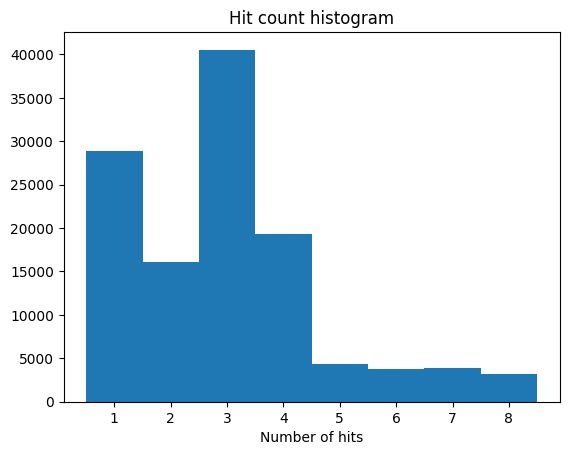

In [4]:
def plot_hit_count_histogram(dataset, title='Hit count histogram'):
    hit_count_histogram = [event_data.get_hit_count() for event_data in dataset.values()]

    plt.hist(hit_count_histogram, bins=range(1, 8 + 2), align='left')
    plt.title(title)
    plt.xlabel('Number of hits')
    
plot_hit_count_histogram(original_dataset)
plt.show()

# Utils

In [5]:
def plot_channel_data(data_dict, suptitle, xlabel, thresholds=None, bins=50):
    plt.figure(figsize=(16, 6.5))
    plt.rc('font', size=8.5)
    for i, ((plane, channel), data) in enumerate(sorted(data_dict.items())):
        plt.subplot(2, 4, i + 1)
        plt.hist(data, bins=bins)
        if thresholds is not None:
            plt.axvline(thresholds[(plane, channel)][0], c='red')
            plt.axvline(thresholds[(plane, channel)][1], c='red')
        plt.title(f'p {plane}, ch {channel}')
        plt.xlabel(xlabel)

    plt.suptitle(suptitle)
    plt.tight_layout()
    plt.show()

# Remove saturated and noisy events

In [6]:
channel_vmax_thresholds = {
    (0, 2):  (1.01, 1.02), # don't take anything
    (0, 11): (1.01, 1.02), # don't take anything
    (1, 2):  (0.36, 0.72),
    (1, 11): (0.36, 0.72),
    (2, 2):  (0.36, 0.72),
    (2, 11): (0.34, 0.72),
    (3, 2):  (0.34, 0.72),
    (3, 11): (0.32, 0.72)
}

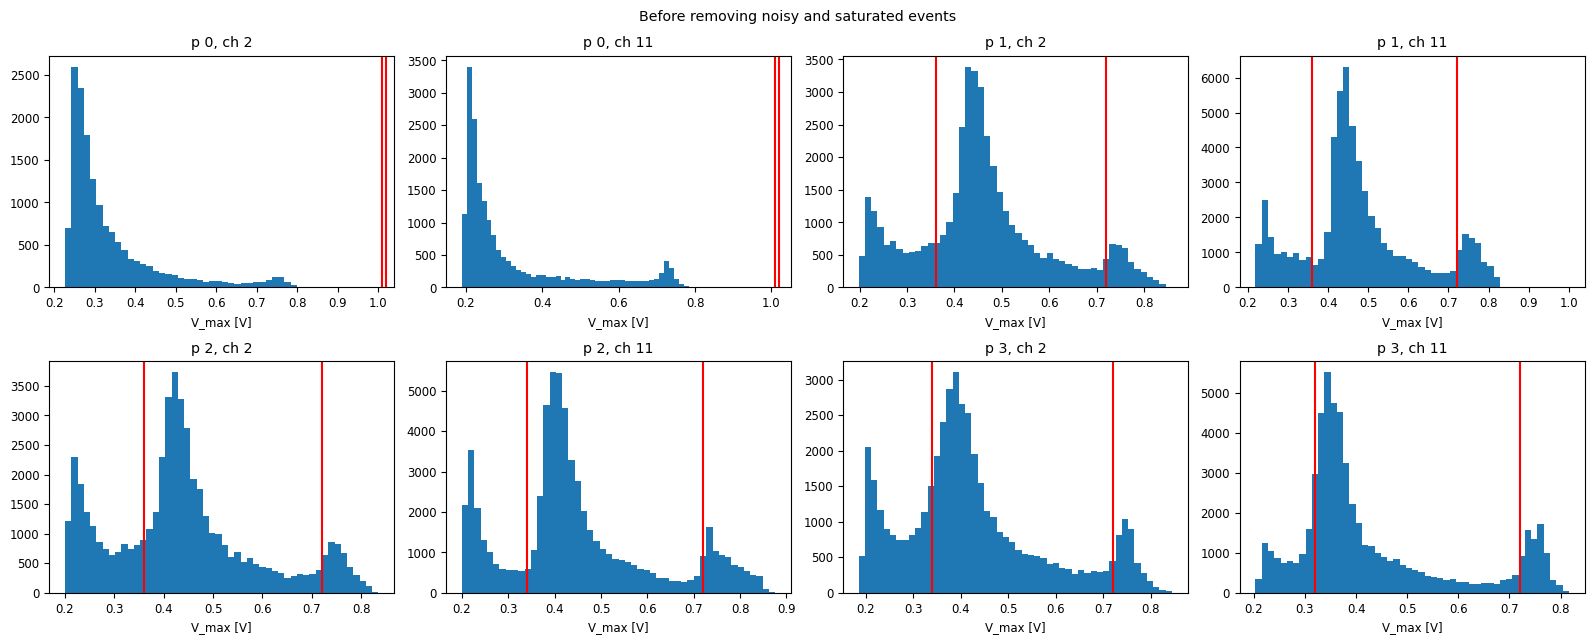

In [7]:
vmax_histograms = defaultdict(list)
for event, event_data in original_dataset.items():
    for plane, plane_data in event_data.planes.items():
        for channel, wav_data in plane_data.items():
            vmax_histograms[(plane, channel)].append(np.max(wav_data.series[1]))
            
plot_channel_data(vmax_histograms, 'Before removing noisy and saturated events', 'V_max [V]', channel_vmax_thresholds)

In [8]:
vmax_dataset = copy.deepcopy(original_dataset)

for event, event_data in vmax_dataset.items():
    for plane, plane_data in list(event_data.planes.items()):
        for channel, wav_data in list(plane_data.items()):
            thresholds = channel_vmax_thresholds[(plane, channel)]
            if not thresholds[0] <= np.max(wav_data.series[1]) <= thresholds[1]:
                event_data.remove_channel(plane, channel)

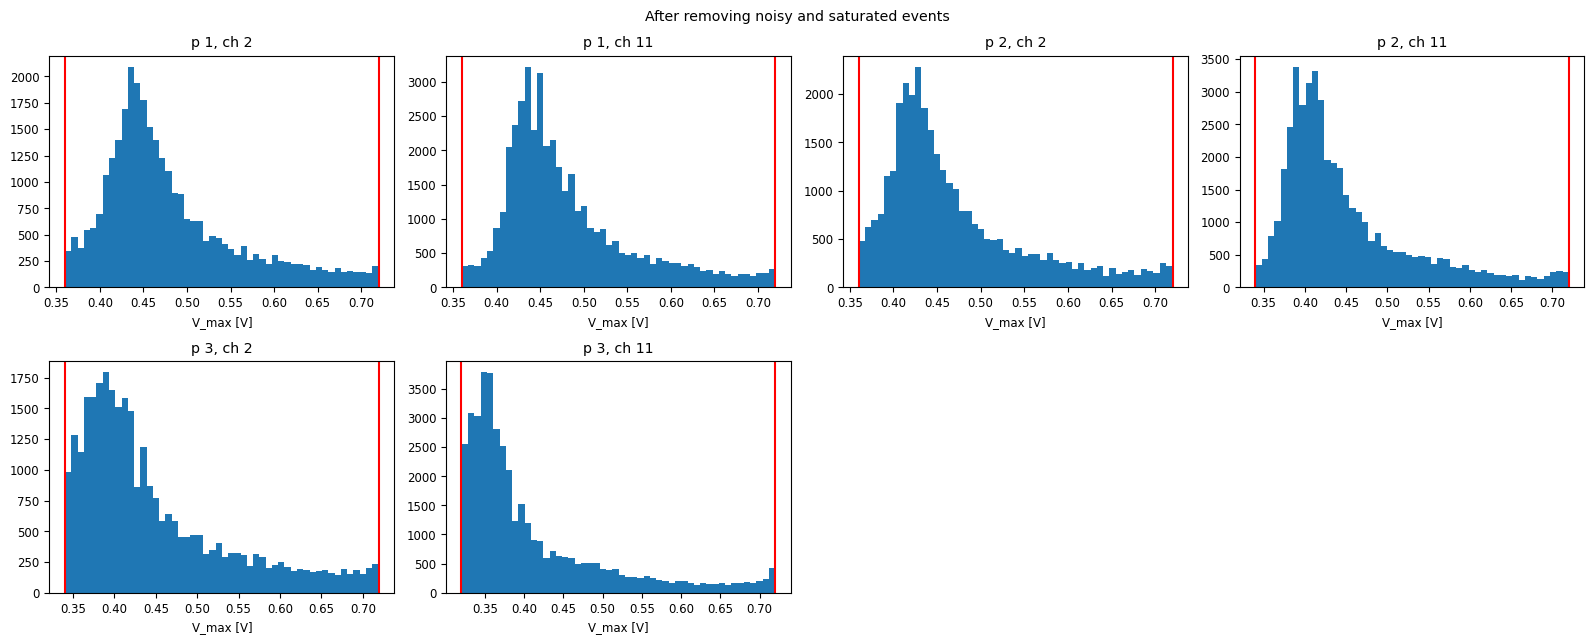

In [9]:
vmax_histograms = defaultdict(list)
for event, event_data in vmax_dataset.items():
    for plane, plane_data in event_data.planes.items():
        for channel, wav_data in plane_data.items():
            vmax_histograms[(plane, channel)].append(np.max(wav_data.series[1]))

plot_channel_data(vmax_histograms, 'After removing noisy and saturated events', 'V_max [V]', channel_vmax_thresholds)

# t0 histograms

In [10]:
# 8 1/3
channel_t0_thresholds = {
    (0, 2):  (-2, 2),
    (0, 11): (2, 2),
    (1, 2):  (-2, 2),
    (1, 11): (-2, 2),
    (2, 2):  (-1, 3),
    (2, 11): (-2, 2),
    (3, 2):  (-1, 3),
    (3, 11): (0.5, 4.5)
}

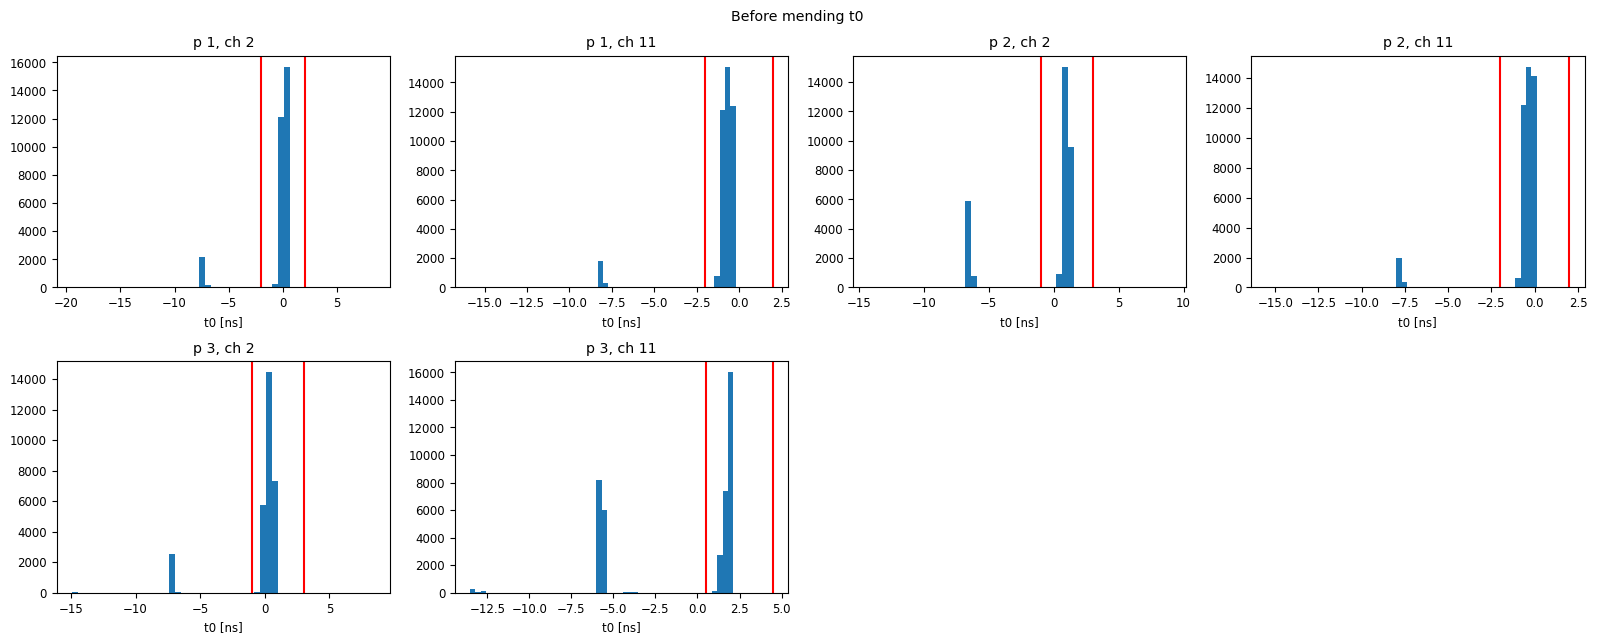

In [11]:
def t0_mod(x):
    return (x + 4.1667) % 8.3333 - 4.1667

t0_dict = defaultdict(list)
for event_data in vmax_dataset.values():
    for plane, channel, wav_data in event_data.get_all_waveforms():
        t0_dict[(plane, channel)].append(wav_data.t0)

plot_channel_data(t0_dict, 'Before mending t0', 't0 [ns]', channel_t0_thresholds, bins=50)

In [12]:
t0_dataset = copy.deepcopy(vmax_dataset)

for event, event_data in t0_dataset.items():
    for plane, plane_data in list(event_data.planes.items()):
        for channel, wav_data in list(plane_data.items()):
            wav_data.t0 = t0_mod(wav_data.t0)
            thresholds = channel_t0_thresholds[(plane, channel)]
            if not thresholds[0] <= wav_data.t0 <= thresholds[1]:
                event_data.remove_channel(plane, channel)

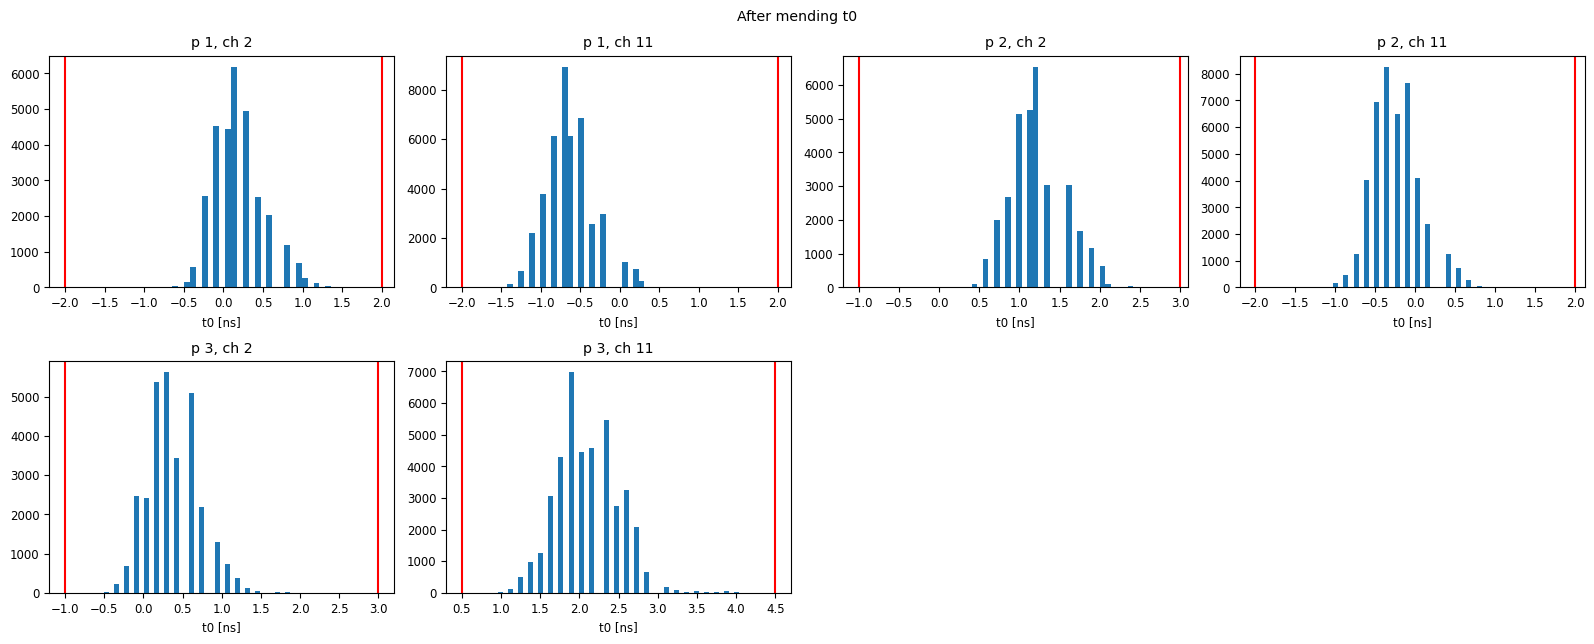

In [13]:
t0_dict = defaultdict(list)
for event_data in t0_dataset.values():
    for plane, channel, wav_data in event_data.get_all_waveforms():
        t0_dict[(plane, channel)].append(wav_data.t0)

plot_channel_data(t0_dict, 'After mending t0', 't0 [ns]', channel_t0_thresholds, bins=50)

# Calculate CFD timestamps and adjust t0

In [14]:
cfd_dataset = copy.deepcopy(t0_dataset)
cfd_avg_shift_applied = False

cfd = CFD(n_baseline=6)
for event, event_data in cfd_dataset.items():
    for plane, plane_data in list(event_data.planes.items()):
        for channel, wav_data in list(plane_data.items()):
            t = cfd.predict(wav_data.series[0], wav_data.series[1])
            if t is None: # Remove the events where CFD cannot be calculated
                event_data.remove_channel(plane, channel)
            else:
                wav_data.t_cfd = t

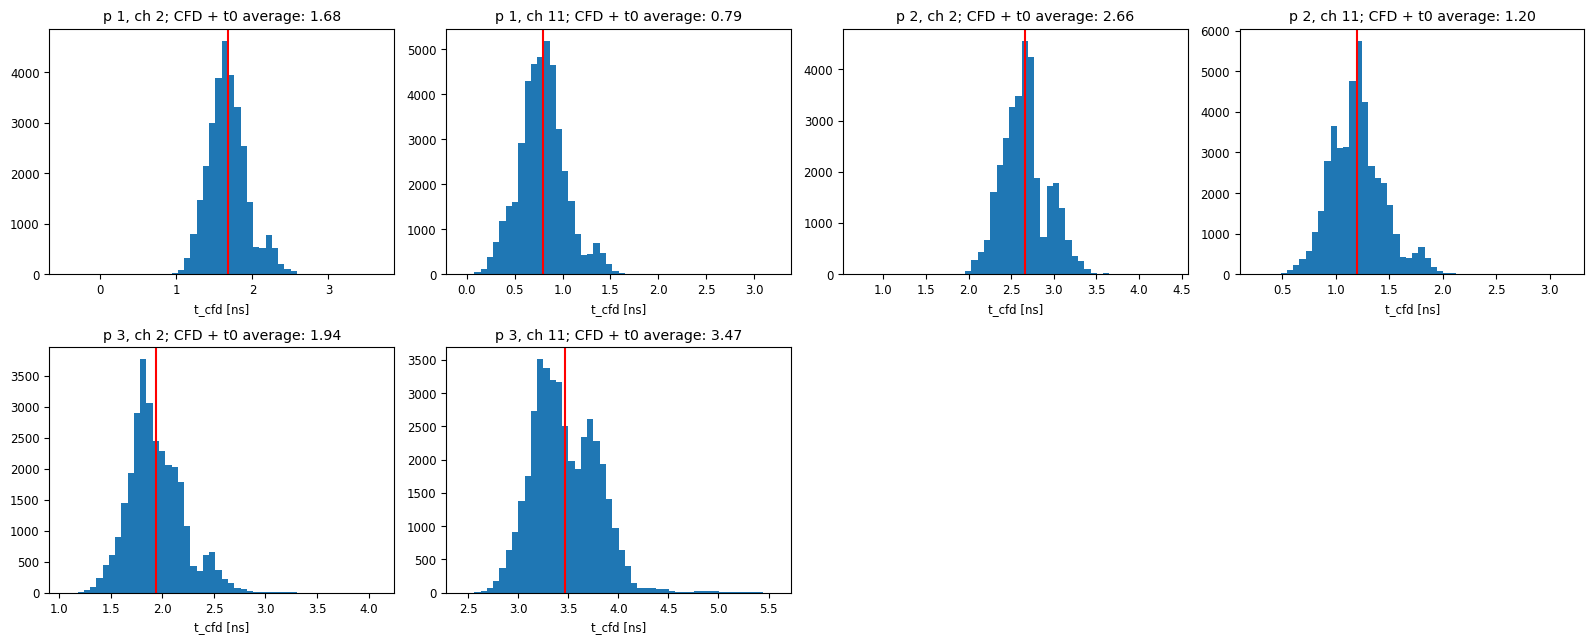

In [15]:
cfd_histograms = defaultdict(list)
for event, event_data in cfd_dataset.items():
    for plane, plane_data in event_data.planes.items():
        for channel, wav_data in plane_data.items():
            cfd_histograms[(plane, channel)].append(wav_data.t_cfd + wav_data.t0)
            
channel_cfd_averages = {}
for (plane, channel), cfds in sorted(cfd_histograms.items()):
    channel_cfd_averages[(plane, channel)] = np.average(cfds)

plt.figure(figsize=(16, 6.5))
plt.rc('font', size=8.5)
for i, ((plane, channel), cfds) in enumerate(sorted(cfd_histograms.items())):
    plt.subplot(2, 4, i + 1)
    plt.hist(cfds, bins=50)
    cfd_avg = channel_cfd_averages[(plane, channel)]
    plt.axvline(cfd_avg, c='red')
    plt.title(f'p {plane}, ch {channel}; CFD + t0 average: {cfd_avg:0.2f}')
    plt.xlabel('t_cfd [ns]')
    
plt.tight_layout()
plt.show()

In [16]:
if not cfd_avg_shift_applied:
    for event, event_data in cfd_dataset.items():
        for plane, plane_data in event_data.planes.items():
            for channel, wav_data in plane_data.items():
                wav_data.t0 -= channel_cfd_averages[(plane, channel)]
                pass

cfd_avg_shift_applied = True

# Take only interesting events

In [17]:
plane_count = 3
hit_count = 3

In [18]:
interesting_dataset = cfd_dataset = copy.deepcopy(cfd_dataset)

for event, event_data in list(interesting_dataset.items()):
    if event_data.get_plane_count() != plane_count or event_data.get_hit_count() != hit_count:
        del interesting_dataset[event]

# Calculate CFD event averages and clear the dataset

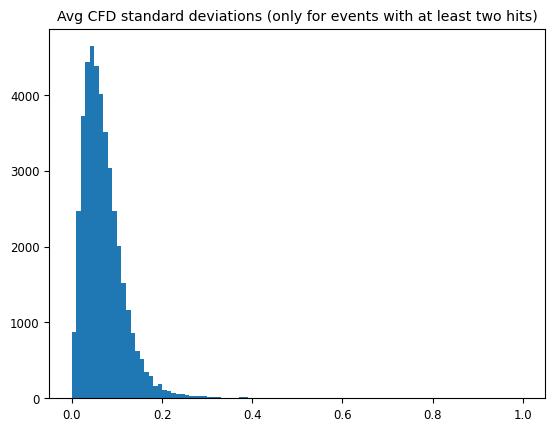

In [19]:
stds = []
for event, event_data in list(interesting_dataset.items()):
    cfds = [wav_data.t_cfd + wav_data.t0 for _, _, wav_data in event_data.get_all_waveforms()]
    # cfds = [wav_data.t_cfd for _, _, wav_data in event_data.get_all_waveforms()]
    if not cfds: # Remove event if empty after the selection
        del interesting_dataset[event]
    else:
        event_data.t_cfd_average = np.average(cfds)
        if len(cfds) >= 2:
            stds.append(np.std(cfds))
                        
plt.hist(stds, range=(0, 1), bins=100)
plt.title('Avg CFD standard deviations (only for events with at least two hits)')
plt.show()

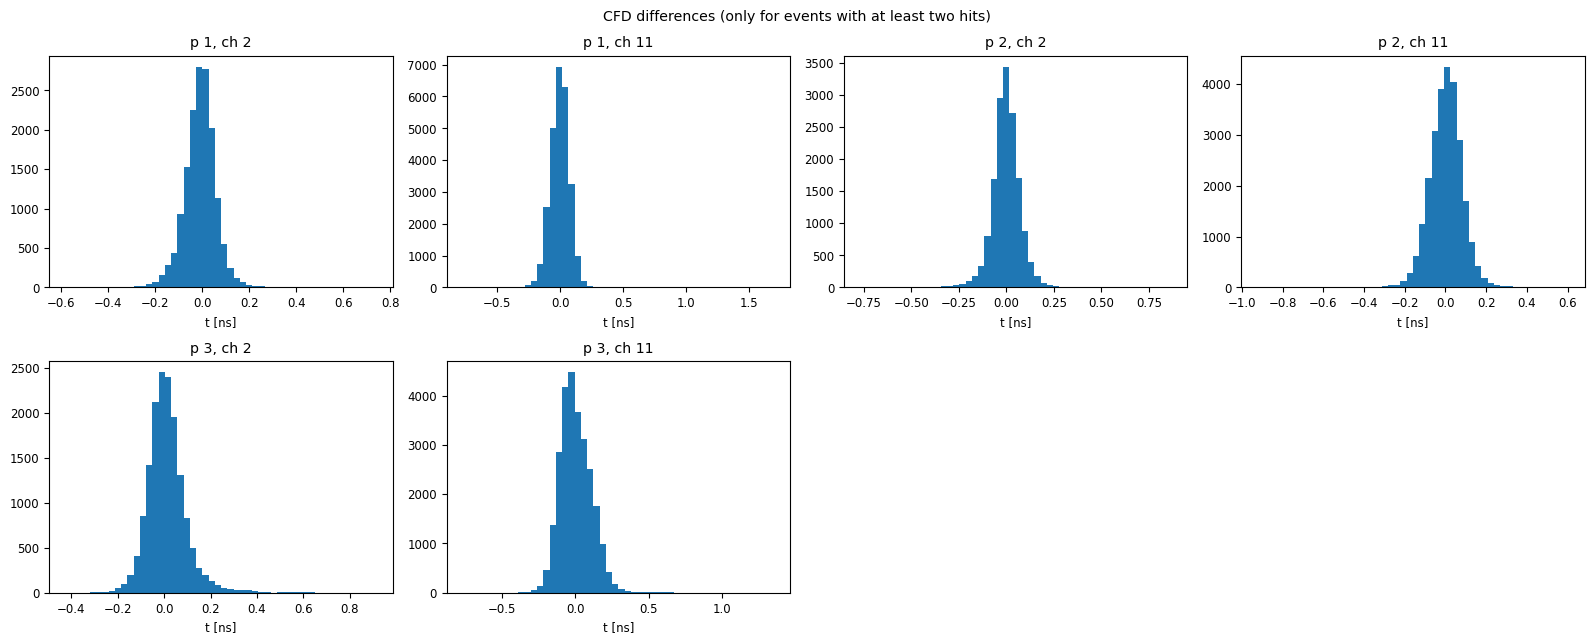

In [20]:
cfd_differences = defaultdict(list)
for event, event_data in interesting_dataset.items():
    if event_data.get_hit_count() >= 2:
        for plane, plane_data in event_data.planes.items():
            for channel, wav_data in plane_data.items():
                cfd_differences[(plane, channel)].append(wav_data.t_cfd + wav_data.t0 - event_data.t_cfd_average)
                # cfd_differences[(plane, channel)].append(wav_data.t_cfd - event_data.t_cfd_average)

plot_channel_data(cfd_differences, 'CFD differences (only for events with at least two hits)', 't [ns]')

# Examples

In [21]:
dataset = interesting_dataset

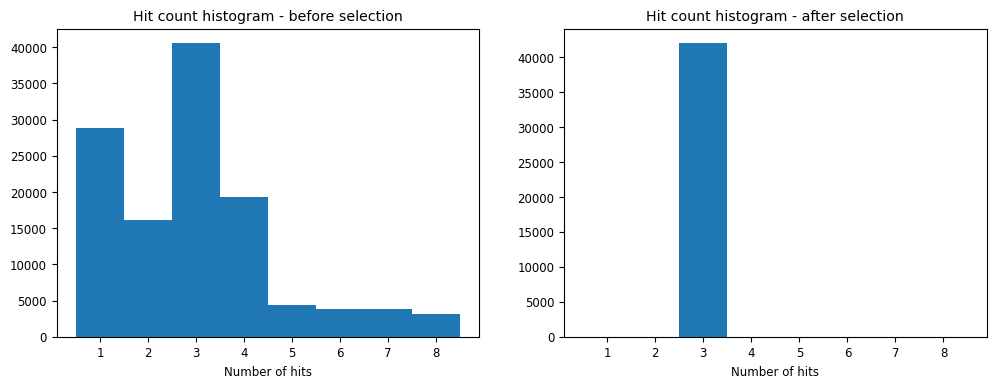

In [22]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plot_hit_count_histogram(original_dataset, title='Hit count histogram - before selection')

plt.subplot(1, 2, 2)
plot_hit_count_histogram(dataset, title='Hit count histogram - after selection')

plt.show()

In [23]:
events_to_view = []
for event, event_data in dataset.items():
    if event_data.get_plane_count() == 3 and event_data.get_hit_count() == 3:
        events_to_view.append(event)
    if len(events_to_view) == 8:
        break
        
events_to_view

[3375, 9900, 17550, 19792, 24253, 25595, 26550, 27904]

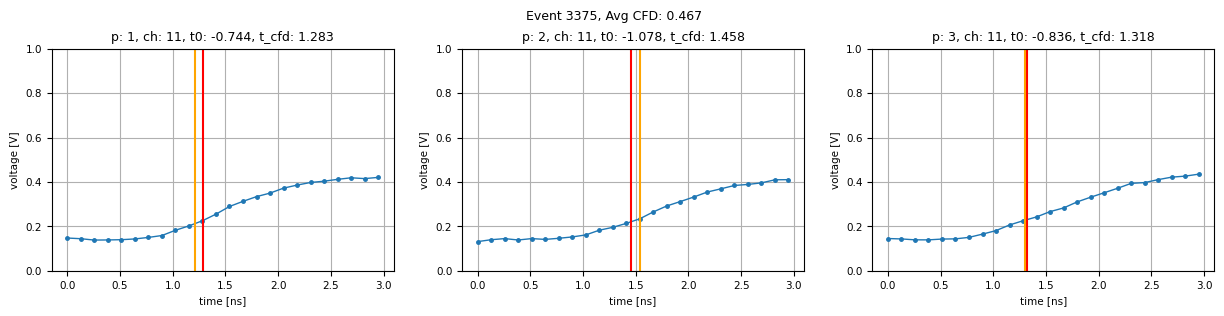

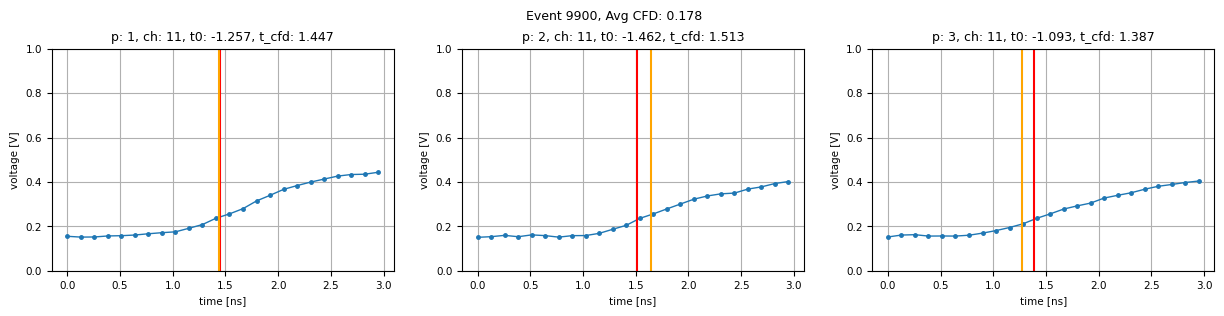

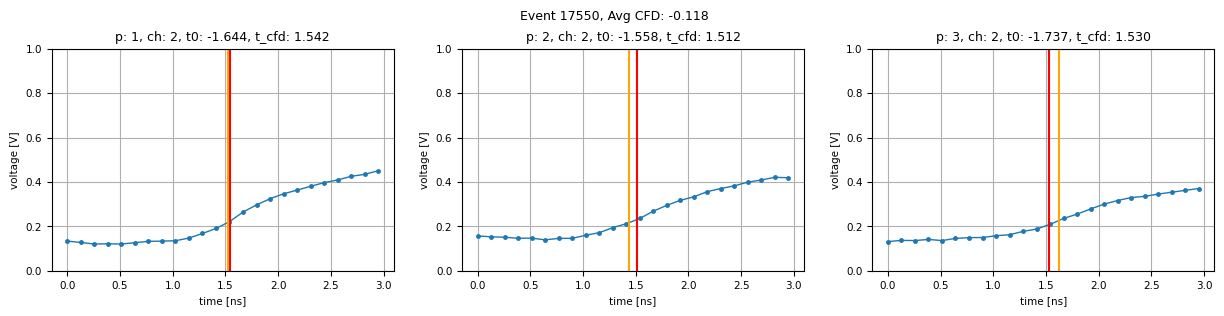

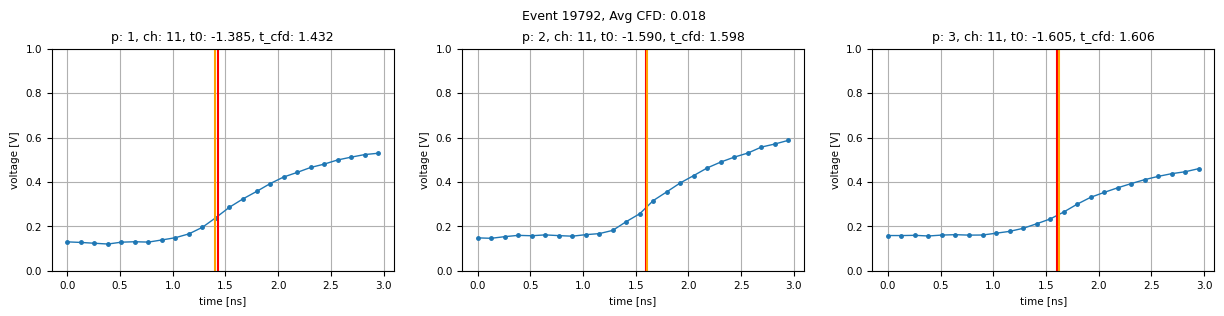

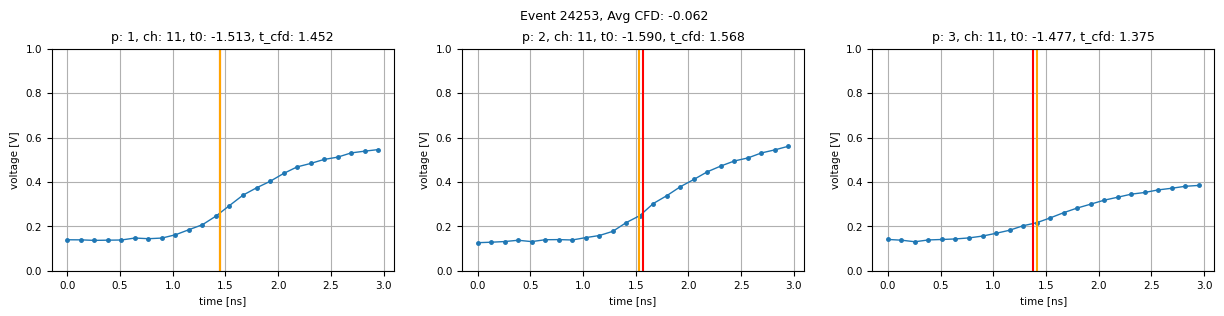

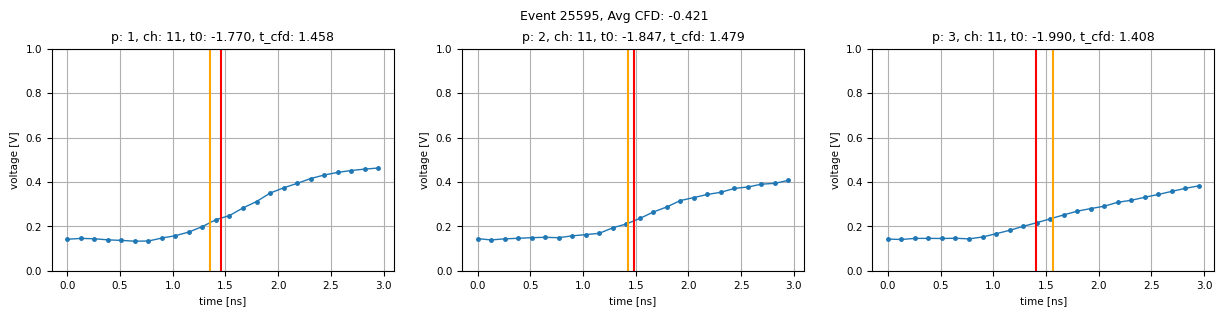

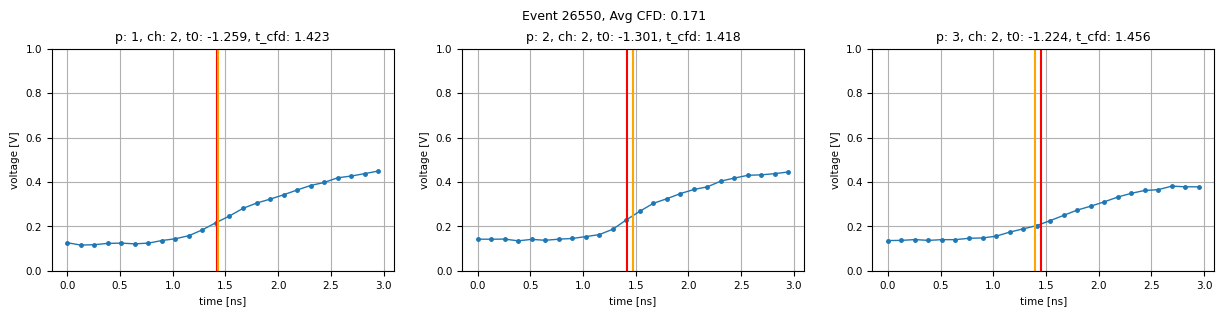

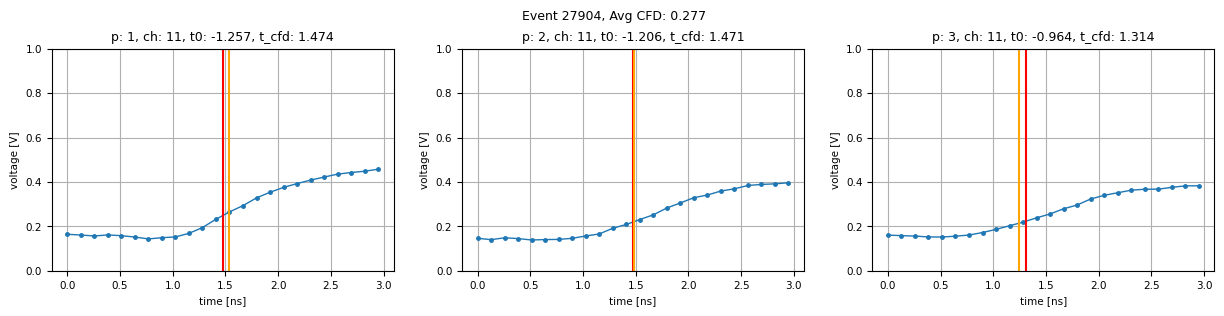

In [24]:
for event in events_to_view:
    plt.figure(figsize=(15, 3))
    plt.rc('font', size=7.5)
    
    for i, (plane, channel, wav_data) in enumerate(dataset[event].get_all_waveforms()):
        plt.subplot(1, 3, i + 1)
        plt.plot(wav_data.series[0], wav_data.series[1], marker='.', linewidth=1, markersize=5)
        if wav_data.t_cfd is not None:
            plt.axvline(wav_data.t_cfd, c='red')
        plt.axvline(dataset[event].t_cfd_average - wav_data.t0, c='orange')
        plt.ylim(0, 1)
        t_cfd_str = f'{wav_data.t_cfd:0.3f}' if wav_data.t_cfd is not None else 'None'
        plt.title(f'p: {plane}, ch: {channel}, t0: {wav_data.t0:0.3f}, t_cfd: {t_cfd_str}')
        plt.xlabel('time [ns]')
        plt.ylabel('voltage [V]')
        plt.grid()
        # print(f'({plane}, {channel}): {wav_data.t_cfd + wav_data.t0:0.2f}')
    
    # plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.suptitle(f'Event {event}, Avg CFD: {dataset[event].t_cfd_average:0.3f}')
    
    plt.show()

In [25]:
for event in events_to_view[:2]:
    print('Event:', event)
    pprint(dataset[event].get_metadata_dict())

Event: 3375
{'plane 1': {'channel 11': "{'t0': -0.7440185177107289, 't_cfd': "
                           '1.2832473638185662}'},
 'plane 2': {'channel 11': "{'t0': -1.0775180065639833, 't_cfd': "
                           '1.4584669565651447}'},
 'plane 3': {'channel 11': "{'t0': -0.8361706782781768, 't_cfd': "
                           '1.3183062842384388}'}}
Event: 9900
{'plane 1': {'channel 11': "{'t0': -1.2568048520346116, 't_cfd': "
                           '1.4467727250942028}'},
 'plane 2': {'channel 11': "{'t0': -1.4621329510219911, 't_cfd': "
                           '1.5132998938243876}'},
 'plane 3': {'channel 11': "{'t0': -1.0925808001959014, 't_cfd': "
                           '1.3865012558978886}'}}


# Produce and save the dataset

In [26]:
final_dataset = defaultdict(lambda: [[], []])

for event, event_data in dataset.items():
    for plane, plane_data in list(event_data.planes.items()):
        for channel, wav_data in list(plane_data.items()):
            final_dataset[(plane, channel)][0].append(wav_data.series[1])                     # series (x)
            final_dataset[(plane, channel)][1].append(event_data.t_cfd_average - wav_data.t0) # ground truth t_cfd (y)
            
final_dataset = dict(sorted(final_dataset.items())) # sort to have expected plane/channel order

for plane, channel in final_dataset:
    final_dataset[(plane, channel)][0] = np.array(final_dataset[(plane, channel)][0])
    final_dataset[(plane, channel)][1] = np.array(final_dataset[(plane, channel)][1])

In [27]:
# store the dataset
with open(DATASET_PATH, 'wb') as file:
    pickle.dump(final_dataset, file)

In [28]:
for plane, channel in sorted(final_dataset.keys()):
    data = final_dataset[(plane, channel)]
    print(f'p {plane}, ch {channel:>2}; {len(data[1])} events')

p 1, ch  2; 15587 events
p 1, ch 11; 26379 events
p 2, ch  2; 15671 events
p 2, ch 11; 26295 events
p 3, ch  2; 15556 events
p 3, ch 11; 26410 events
